In [77]:
%pylab inline

import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import mean_absolute_error

import datetime, time

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [56]:
# Read data
wnv_train = pd.read_csv('../working/train_f.csv', index_col=0)
wnv_test = pd.read_csv('../working/test_f.csv', index_col=0)

In [57]:
output = 'WnvPresent'

labels = wnv_train[output].values.astype('int')
yr_train = labels
wnv_train.drop('NumMosquitos', axis=1, inplace=True)
wnv_train.drop('WnvPresent', axis=1, inplace=True)
f_names = wnv_train.columns

if 'NumMosquitos' in wnv_test:
    wnv_test.drop('NumMosquitos', axis=1, inplace=True)
    
if 'WnvPresent' in wnv_test:
    wnv_test.drop('WnvPresent', axis=1, inplace=True)

In [58]:
# raw data
#yr_train = wnv_train[:,1].astype(int)
Xr_train =(wnv_train.values).astype('float64')
Xr_test =(wnv_test.values).astype('float64')

# normalize data
scaler = StandardScaler()
scaler.fit(Xr_train)
Xn_train = scaler.transform(Xr_train)
Xn_test = scaler.transform(Xr_test)

X_train, X_test, y_train, y_test = train_test_split(Xn_train, yr_train)

In [100]:
clf = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=10, scoring='mean_squared_error')
#clf = ExtraTreesRegressor(n_estimators=5000, n_jobs=3)
clf.fit(X_train, y_train)

# use the model to predict the labels of the test data
proba = clf.predict(X_test)
#proba = clf.predict_proba(X_test)
expected = y_test

In [101]:
print clf.score(X_test, y_test)
#mean_absolute_error(y_test, predicted)

0.0507252627905


Area under the ROC curve : 0.766068


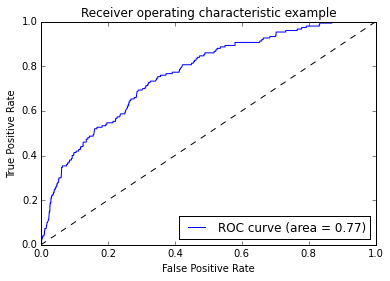

In [102]:
fpr, tpr, thresholds = roc_curve(expected, proba)
roc_auc = auc(fpr, tpr)
print "Area under the ROC curve : %f" % roc_auc

# Plot ROC curve
plt.clf()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [103]:
wnv_test[output] = clf.predict(Xn_test)

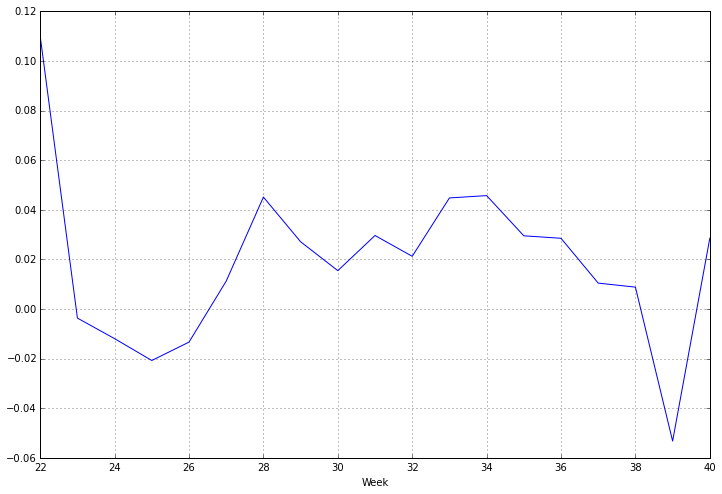

In [104]:
# output by week
df = wnv_test.groupby(['Week'])[output].agg(np.mean)
#df = g.unstack(level=[0])
df.plot(kind='line', figsize=(12, 8))

In [107]:
#wnv_test.to_csv('../working/test_fn.csv')

In [108]:
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')

def write_preds(proba, fname):
    pd.DataFrame({"Id": list(range(1,len(proba)+1)), "WnvPresent": proba}).to_csv(fname, index=False, header=True)

write_preds(proba, "../working/sklearn_lr_" + st + ".csv")